# Linear model

Здесь мы протестируем модель линейной регрессии и случайного леса из пакета sklearn.

In [1]:
import os
import gc
import tqdm
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix

In [2]:
# путь до данных на компьютере
path = 'data/train_data/'

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns).drop_duplicates()
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [4]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных
        #закодируем категории
        ohe = OneHotEncoder(sparse_output=False, max_categories=10, drop='first')
        encoded_frame = ohe.fit_transform(transactions_frame.drop(['id', 'rn'], axis=1))
        
        #объединим закодированные категории с id
        data_preprocessed = pd.concat([transactions_frame['id'], 
                                       pd.DataFrame(encoded_frame, columns=ohe.get_feature_names_out())], axis=1)
        del transactions_frame, encoded_frame
        gc.collect()
        
        #агрегируем по id: суммируем закодированные фичи по каждому клиенту
        data_grouped = data_preprocessed.groupby('id', as_index=False).agg('sum')
        del data_preprocessed
        gc.collect()
        
        
   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            data_grouped.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(data_grouped)
        del data_grouped
        gc.collect()
        
    #смерджим по id с таргетом
    targets = pd.read_csv('data/train_target/train_target.csv')
    return pd.concat(preprocessed_frames).fillna(0.).merge(targets, how='inner', on='id')

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
start = datetime.now()

Прочитаем и обработаем данные:

In [7]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=1, num_parts_total=6)

Transforming transactions data:   0%|          | 0/6 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_10.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path data/train_data/train_data_3.pq


In [8]:
# пример полученных данных
data.head()

,id,pre_since_opened_2,pre_since_opened_4,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_13,pre_since_opened_18,pre_since_opened_19,pre_since_opened_infrequent_sklearn,...,pre_since_opened_3,pre_since_confirmed_12,pre_till_pclose_10,pre_loans_credit_limit_4,pre_over2limit_11,pre_since_opened_1,pre_pterm_15,pre_since_confirmed_2,pre_over2limit_9,flag
0,0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,1.0,2.0,3.0,0.0,0.0,3.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Columns: 294 entries, id to flag
dtypes: float64(292), int64(2)
memory usage: 3.3 GB


# Обучение модели

In [10]:
# Объявим список результатов метрики различных моделей
scores = []

In [11]:
X = data.drop(['id', 'flag'], axis=1)
y = data['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12, 
                                                    stratify=y, shuffle=True)

del data, X, y
gc.collect()

18

## Дефолтная логистическая регрессия

In [12]:
logreg = LogisticRegression(n_jobs=-1, random_state=12)
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=12)

In [13]:
y_pred = logreg.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    289950
           1       0.18      0.00      0.00     10050

    accuracy                           0.97    300000
   macro avg       0.58      0.50      0.49    300000
weighted avg       0.94      0.97      0.95    300000



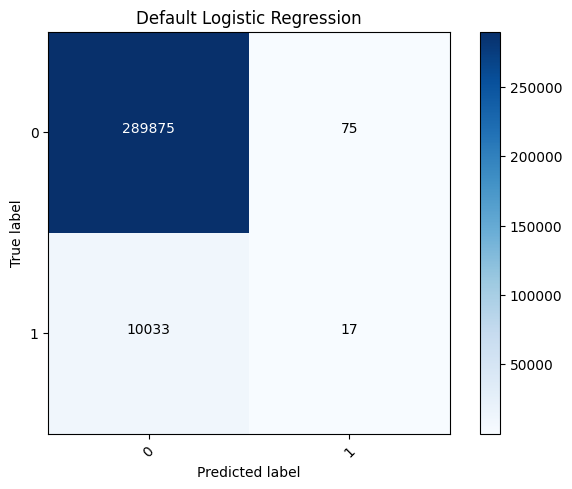

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Default Logistic Regression')
plt.savefig('pictures/Linear_model_1.png', bbox_inches='tight');

**Дефолтная логистическая регрессия плохо размечает положительный класс.**

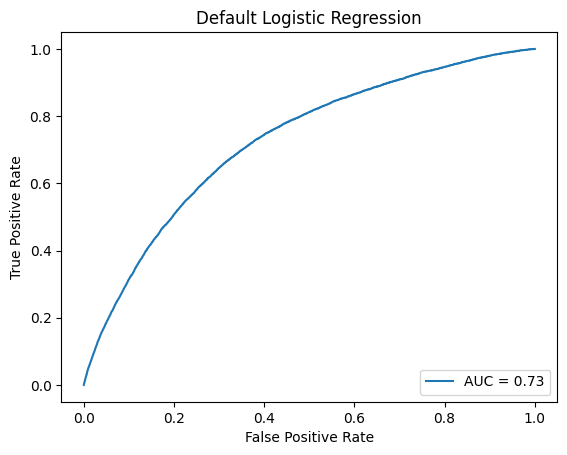

In [16]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('Default Logistic Regression')
plt.savefig('pictures/Linear_model_2.png', bbox_inches='tight');

**Значение метрики auc ниже целевого порога. Попробуем подобрать гиперпараметры.**

## Подбор параметров GridSearchCV

In [17]:
model = LogisticRegression(solver='newton-cholesky', class_weight='balanced', random_state=12, n_jobs=-1)
param_grid = {'C': [1, 3, 5]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, 
                  cv=3, scoring='roc_auc', n_jobs=-1, verbose=True)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

Fitting 3 folds for each of 3 candidates, totalling 9 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,23.601241,0.065890,0.791650,0.024545,1,{'C': 1},0.732104,0.726757,0.736376,0.731745,0.003935,1
1,23.587072,0.050281,0.785515,0.018940,3,{'C': 3},0.732117,0.726729,0.736375,0.731740,0.003947,2
2,23.517318,0.061872,0.793943,0.024904,5,{'C': 5},0.732121,0.726724,0.736376,0.731740,0.003950,3


In [18]:
y_pred = gs.best_estimator_.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    289950
           1       0.07      0.68      0.12     10050

    accuracy                           0.68    300000
   macro avg       0.53      0.68      0.46    300000
weighted avg       0.95      0.68      0.78    300000



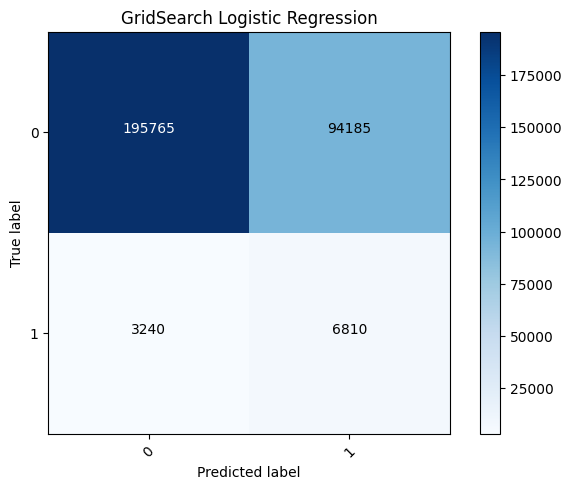

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='GridSearch Logistic Regression')
plt.savefig('pictures/Linear_model_3.png', bbox_inches='tight');

**После подбора параметров картина изменилась. Модель способна верно определять мошенников: recall=0.68. При этом много заявок по ошибке отклоняются, но для банкинга это приемлемая ситуация.**

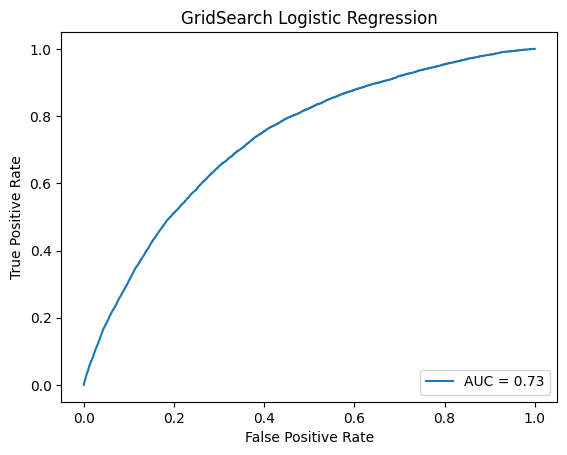

In [21]:
y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('GridSearch Logistic Regression')
plt.savefig('pictures/Linear_model_4.png', bbox_inches='tight');

**Значение auc немного увеличилась, но все еще меньше целевого значения.**

## Модель случайного леса

In [22]:
tree = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=12)
tree.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=12)

In [23]:
y_pred = tree.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    289950
           1       0.22      0.00      0.01     10050

    accuracy                           0.97    300000
   macro avg       0.59      0.50      0.50    300000
weighted avg       0.94      0.97      0.95    300000



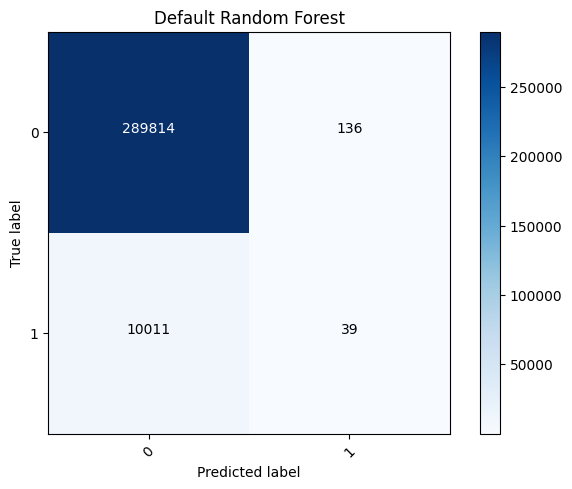

In [25]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Default Random Forest')
plt.savefig('pictures/Linear_model_5.png', bbox_inches='tight');

**Так же, как и для логистической регрессии с дефолтными параметрами модель обладает плохой способностью помечать положительный класс.**

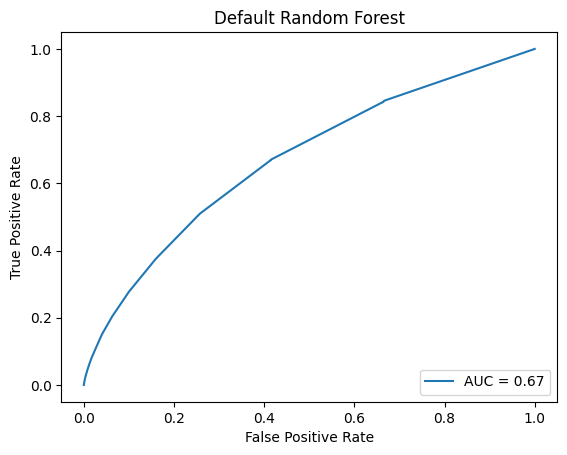

In [26]:
y_pred_proba = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('Default Random Forest')
plt.savefig('pictures/Linear_model_6.png', bbox_inches='tight');

**Значение метрики auc сильно меньше целевого значения. Попробуем подобрать гиперпараметры.**

## Подбор параметров GridSearchCV

In [27]:
model = RandomForestClassifier(n_estimators=50, random_state=12, class_weight='balanced', n_jobs=-1)
param_grid = {'max_depth': [5, 9],
              'min_samples_leaf': [2, 9]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, 
                  cv=3, scoring='roc_auc', n_jobs=-1, verbose=True)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,73.620564,0.076925,1.552241,0.032878,9,2,"{'max_depth': 9, 'min_samples_leaf': 2}",0.720684,0.719255,0.728541,0.722827,0.004082,1
3,73.595175,0.023025,1.563650,0.055516,9,9,"{'max_depth': 9, 'min_samples_leaf': 9}",0.720157,0.718542,0.727904,0.722201,0.004086,2
1,62.990261,0.343026,6.444335,0.237116,5,9,"{'max_depth': 5, 'min_samples_leaf': 9}",0.702588,0.700440,0.709231,0.704086,0.003742,3
0,63.099479,0.064117,6.426220,0.051949,5,2,"{'max_depth': 5, 'min_samples_leaf': 2}",0.701946,0.700494,0.709278,0.703906,0.003845,4


In [28]:
y_pred = gs.best_estimator_.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82    289950
           1       0.07      0.61      0.12     10050

    accuracy                           0.70    300000
   macro avg       0.52      0.66      0.47    300000
weighted avg       0.95      0.70      0.80    300000



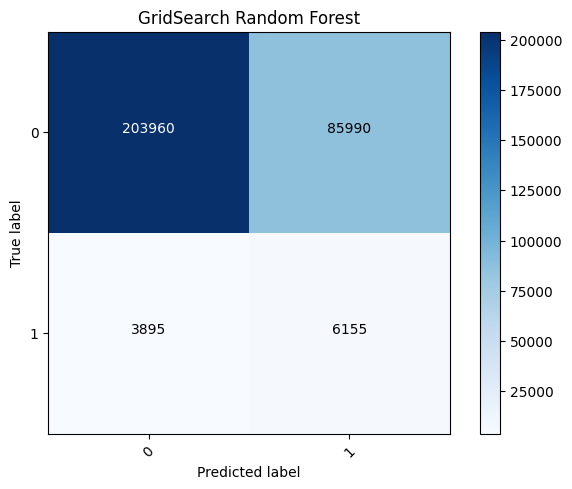

In [30]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='GridSearch Random Forest')
plt.savefig('pictures/Linear_model_7.png', bbox_inches='tight');

**После подбора параметров лучшая модель научилась предсказывать мошенников: recall=0.61**

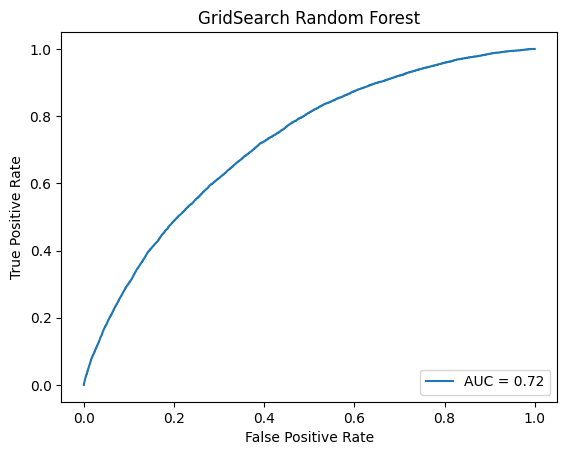

In [31]:
y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
scores.append(roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('GridSearch Random Forest')
plt.savefig('pictures/Linear_model_8.png', bbox_inches='tight');

**Так же значение метрики сильно увеличилось, но все еще недостаточно. В целом, можно объяснить такие результаты недостатком данных, потому как для обучения таких моделей нужно загружать все данные в один датафрейм, что требует огромных вычислительных ресурсов и не является целесообразным.**

# Результаты

Сохраним лучшие результаты в таблицу scores:

In [32]:
df_scores = pd.read_csv('data/scores.csv')
df_scores.loc[df_scores['model'] == 'Linear', 'score'] = max(scores)

time = datetime.now() - start
df_scores.loc[df_scores['model'] == 'Linear', 'time'] = int(time.seconds)
df_scores.head()

,model,score,time
0,Single,0.769174,223.0
1,Ensemble,0.774852,475.0
2,Linear,0.732219,444.0
3,CatBoost,0.768903,492.0
4,LightGBM,0.775573,118.0


In [33]:
df_scores.to_csv('data/scores.csv', index=False)